In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np


In [1]:
# Downloading UFC fight data from Kaggle using the opendatasets library
import opendatasets as od

# Downloading the dataset
od.download("https://www.kaggle.com/datasets/remypereira/mma-dataset-2023-ufc", 
            username="bryantndongmo", 
            password="d447ca91c20fd123b49f35fe29a0689d")


Skipping, found downloaded files in ".\mma-dataset-2023-ufc" (use force=True to force download)


In [3]:
# Load downloaded datasets with Pandas
fight_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fight_data.csv')
fighter_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fighter_data.csv')
fight_stat_data = pd.read_csv('mma-dataset-2023-ufc/ufc_fight_stat_data.csv')
event_data = pd.read_csv('mma-dataset-2023-ufc/ufc_event_data.csv')

In [4]:
# Creating dictionaries to map fight_id to event_id and event_id to event_date
fight_to_event = dict(zip(fight_data['fight_id'], fight_data['event_id']))
event_to_date = dict(zip(event_data['event_id'], event_data['event_date']))


In [5]:
# Early fights don't have control time data so will exclude
fight_stat_data = fight_stat_data[fight_stat_data.fight_id >= 2505]

In [6]:
#Visualize fight stat distributions
fight_stat_data[fight_stat_data.columns[3:]].hist(bins=50, figsize=(15,15))

array([[<Axes: title={'center': 'knockdowns'}>,
        <Axes: title={'center': 'total_strikes_att'}>,
        <Axes: title={'center': 'total_strikes_succ'}>],
       [<Axes: title={'center': 'sig_strikes_att'}>,
        <Axes: title={'center': 'sig_strikes_succ'}>,
        <Axes: title={'center': 'takedown_att'}>],
       [<Axes: title={'center': 'takedown_succ'}>,
        <Axes: title={'center': 'submission_att'}>,
        <Axes: title={'center': 'reversals'}>]], dtype=object)

# Feature Engineering

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Columns to impute
columns_to_impute = ['fighter_height_cm', 'fighter_weight_lbs', 'fighter_reach_cm']

# Imputing missing values
imputer = IterativeImputer()
fighter_data[columns_to_impute] = imputer.fit_transform(fighter_data[columns_to_impute])


In [8]:
# Combining first name and last name to create a new column 'name'
fighter_data['name'] = fighter_data['fighter_f_name'] + ' ' + fighter_data['fighter_l_name']
fighter_data

fighter_id fighter_f_name fighter_l_name fighter_nickname  \
0           4107            Tom          Aaron              NaN   
1           4106          Danny         Abbadi     The Assassin   
2           4105        Nariman        Abbasov        Bayraktar   
3           4104          David         Abbott             Tank   
4           4103          Hamdy     Abdelwahab       The Hammer   
...          ...            ...            ...              ...   
4102           5           Dave       Zitanick              NaN   
4103           4           Alex         Zuniga              NaN   
4104           3         George         Zuniga              NaN   
4105           2          Allan         Zuniga            Tigre   
4106           1         Virgil        Zwicker           RezDog   

      fighter_height_cm  fighter_weight_lbs  fighter_reach_cm fighter_stance  \
0            175.831982               155.0        179.967189            NaN   
1            180.340000               155.0        184.125723       Orthodox   
2            172.720000               155.0        167.640000       Orthodox   
3            182.880000               265.0        191.162529         Switch   
4            187.960000               264.0        182.880000       Southpaw   
...                 ...                 ...               ...            ...   
4102         178.109832               170.0        182.708501            NaN   
4103         174.313415               145.0        178.139647            NaN   
4104         175.260000               185.0        180.719655            NaN   
4105         170.180000               155.0        177.800000       Orthodox   
4106         187.960000               205.0        187.960000            NaN   

     fighter_dob  fighter_w  fighter_l  fighter_d  fighter_nc_dq  \
0     1978-07-13          5          3          0            NaN   
1     1983-07-03          4          6          0            NaN   
2     1994-02-01         28          4          0            NaN   
3            NaN         10         15          0            NaN   
4     1993-01-22          5          0          0            1.0   
...          ...        ...        ...        ...            ...   
4102  1980-03-05          5          7          0            1.0   
4103         NaN          6          3          0            NaN   
4104         NaN          3          1          0            NaN   
4105  1992-04-04         13          1          0            NaN   
4106  1982-06-26         15          6          1            NaN   

                                            fighter_url              name  
0     http://ufcstats.com/fighter-details/93fe7332d1...         Tom Aaron  
1     http://ufcstats.com/fighter-details/15df64c02b...      Danny Abbadi  
2     http://ufcstats.com/fighter-details/59a9d6dac6...   Nariman Abbasov  
3     http://ufcstats.com/fighter-details/b361180739...      David Abbott  
4     http://ufcstats.com/fighter-details/3329d692ae...  Hamdy Abdelwahab  
...                                                 ...               ...  
4102  http://ufcstats.com/fighter-details/be124bdd60...     Dave Zitanick  
4103  http://ufcstats.com/fighter-details/02d808afb9...       Alex Zuniga  
4104  http://ufcstats.com/fighter-details/1291dd6b8a...     George Zuniga  
4105  http://ufcstats.com/fighter-details/523af801b3...      Allan Zuniga  
4106  http://ufcstats.com/fighter-details/0c277f3ff6...    Virgil Zwicker  

[4107 rows x 15 columns]

In [9]:
# Creating a dictionary to map fighter_id to fighter name
id_to_name = dict(zip(fighter_data['fighter_id'], fighter_data['name']))

In [10]:
# Merging datasets and processing date-related features
df = pd.merge(fight_stat_data, fight_data, on='fight_id', how='left')
df = pd.merge(df, fighter_data, on='fighter_id', how='left')

# Adding event_date column
df['event_date'] = df['fight_id'].apply(lambda x: event_to_date[fight_to_event[x]])
df['event_date'] = pd.to_datetime(df['event_date'])

# Calculating days since the event
df['days_ago'] = (pd.to_datetime('today') - df['event_date']).dt.days

# Calculating days since last fight
df['last_fight_date'] = pd.to_datetime(df.groupby('fighter_id')['event_date'].shift(-1))
df['last_fight_date_days_ago'] = (pd.to_datetime('today') - df['last_fight_date']).dt.days
df['days_since_last_fight'] = df['last_fight_date_days_ago'] - df['days_ago']

# Calculating fighter's age
df['age'] = (pd.to_datetime('today') - pd.to_datetime(df['fighter_dob'])).dt.days / 365

# Dropping unnecessary columns
df.drop(columns=['last_fight_date'], inplace=True)
df.drop('event_date', axis=1, inplace=True)

df


fight_stat_id  fight_id  fighter_id  knockdowns  total_strikes_att  \
0             14436      7218      2976.0         0.0               34.0   
1             14435      7218      2884.0         0.0               42.0   
2             14434      7217      1662.0         0.0               59.0   
3             14433      7217      2464.0         0.0               72.0   
4             14432      7216       981.0         0.0              130.0   
...             ...       ...         ...         ...                ...   
9423           5013      2507      3872.0         0.0               71.0   
9424           5012      2506      2216.0         0.0                9.0   
9425           5011      2506      3248.0         1.0               32.0   
9426           5010      2505      2432.0         0.0               55.0   
9427           5009      2505      3201.0         0.0              130.0   

      total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                   19.0             32.0              18.0           0.0   
1                   17.0             40.0              16.0           6.0   
2                   37.0             40.0              23.0          15.0   
3                   32.0             55.0              18.0           0.0   
4                   90.0            102.0              70.0           1.0   
...                  ...              ...               ...           ...   
9423                31.0             66.0              26.0           1.0   
9424                 1.0              9.0               1.0           1.0   
9425                10.0             29.0               9.0           1.0   
9426                18.0             54.0              17.0          10.0   
9427                83.0             86.0              43.0           0.0   

      takedown_succ  ...  fighter_w  fighter_l fighter_d fighter_nc_dq  \
0               0.0  ...       12.0        3.0       0.0           NaN   
1               1.0  ...       23.0        2.0       0.0           1.0   
2               5.0  ...       16.0        2.0       0.0           NaN   
3               0.0  ...       17.0        7.0       0.0           NaN   
4               1.0  ...       17.0        3.0       2.0           NaN   
...             ...  ...        ...        ...       ...           ...   
9423            0.0  ...       18.0       10.0       0.0           NaN   
9424            0.0  ...       11.0        3.0       0.0           NaN   
9425            1.0  ...        8.0        5.0       0.0           NaN   
9426            2.0  ...       13.0        6.0       0.0           NaN   
9427            0.0  ...       15.0        8.0       0.0           NaN   

                                            fighter_url              name  \
0     http://ufcstats.com/fighter-details/c814b4c899...     Rafael Fiziev   
1     http://ufcstats.com/fighter-details/72db2a14ff...    Mateusz Gamrot   
2     http://ufcstats.com/fighter-details/d9c6f19f95...    Bryce Mitchell   
3     http://ufcstats.com/fighter-details/82a5152216...           Dan Ige   
4     http://ufcstats.com/fighter-details/cd2c4d30c6...  Marina Rodriguez   
...                                                 ...               ...   
9423  http://ufcstats.com/fighter-details/9a2d3567ab...     Tae Hyun Bang   
9424  http://ufcstats.com/fighter-details/fe91d254db...     Dustin Kimura   
9425  http://ufcstats.com/fighter-details/0d0351c201...   Jon Delos Reyes   
9426  http://ufcstats.com/fighter-details/d1e1fdcea7...      Leandro Issa   
9427  http://ufcstats.com/fighter-details/f50d952237...     Russell Doane   

      days_ago  last_fight_date_days_ago  days_since_last_fight        age  
0          233                     422.0                  189.0  31.210959  
1          233                     436.0                  203.0  33.443836  
2          233                     520.0                  287.0  29.627397  
3          233                     338.0      

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Function to convert time to seconds
def convert_time(t):
    ind = t.index(':')
    seconds = int(t[ind+1:])
    minutes = int(t[:ind])
    return minutes * 60 + seconds

# Function to map result to numerical value
def map_result(f_1, winner, result):
    if 'Decision' in result:
        code = 0
    elif 'TKO' in result:
        code = 1
    else:
        code = 2
    if f_1 != winner:
        code += 3
    return code

# Converting control time and finish time to numerical values in seconds
df['ctrl_time_seconds'] = df['ctrl_time'].apply(lambda t: convert_time(t))
df['finish_time_seconds'] = df['finish_time'].apply(lambda t: convert_time(t) + (df['finish_round'] - 1) * 300)

# Creating a list of opponents
opponents = []
for i in range(0, len(df), 2):
    opponents.append(df.loc[i+1, 'name'])
    opponents.append(df.loc[i, 'name'])
df['opponent'] = opponents
df = df.iloc[::-1]
df['count'] = 1

# Creating binary columns for different fight outcomes
df['win'] = (df.winner == df.fighter_id)  
df['ko_win'] = (df.result.apply(lambda x: 'TKO' in str(x))) & (df.winner == df.fighter_id)  
df['ko_loss'] = (df.result.apply(lambda x: 'TKO' in str(x))) & (df.winner != df.fighter_id)  
df['sub_win'] = (df.result.apply(lambda x: 'Sub' in str(x))) & (df.winner == df.fighter_id)  
df['sub_loss'] = (df.result.apply(lambda x: 'Sub' in str(x))) & (df.winner != df.fighter_id)  
df['dec_win'] = (df.result.apply(lambda x: 'Decision' in str(x))) & (df.winner == df.fighter_id)  
df['dec_loss'] = (df.result.apply(lambda x: 'Decision' in str(x))) & (df.winner != df.fighter_id)  

df


fight_stat_id  fight_id  fighter_id  knockdowns  total_strikes_att  \
9427           5009      2505      3201.0         0.0              130.0   
9426           5010      2505      2432.0         0.0               55.0   
9425           5011      2506      3248.0         1.0               32.0   
9424           5012      2506      2216.0         0.0                9.0   
9423           5013      2507      3872.0         0.0               71.0   
...             ...       ...         ...         ...                ...   
4             14432      7216       981.0         0.0              130.0   
3             14433      7217      2464.0         0.0               72.0   
2             14434      7217      1662.0         0.0               59.0   
1             14435      7218      2884.0         0.0               42.0   
0             14436      7218      2976.0         0.0               34.0   

      total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
9427                83.0             86.0              43.0           0.0   
9426                18.0             54.0              17.0          10.0   
9425                10.0             29.0               9.0           1.0   
9424                 1.0              9.0               1.0           1.0   
9423                31.0             66.0              26.0           1.0   
...                  ...              ...               ...           ...   
4                   90.0            102.0              70.0           1.0   
3                   32.0             55.0              18.0           0.0   
2                   37.0             40.0              23.0          15.0   
1                   17.0             40.0              16.0           6.0   
0                   19.0             32.0              18.0           0.0   

      takedown_succ  ...  finish_time_seconds                 opponent count  \
9427            0.0  ...                  599             Leandro Issa     1   
9426            2.0  ...                  599            Russell Doane     1   
9425            1.0  ...                  133            Dustin Kimura     1   
9424            0.0  ...                  133          Jon Delos Reyes     1   
9423            0.0  ...                  900         Mairbek Taisumov     1   
...             ...  ...                  ...                      ...   ...   
4               1.0  ...                  462  Michelle Waterson-Gomez     1   
3               0.0  ...                  900           Bryce Mitchell     1   
2               5.0  ...                  900                  Dan Ige     1   
1               1.0  ...                  423            Rafael Fiziev     1   
0               0.0  ...                  423           Mateusz Gamrot     1   

        win  ko_win ko_loss  sub_win  sub_loss  dec_win dec_loss  
9427   True   False   False     True     False    False    False  
9426  False   False   False    False      True    False    False  
9425  False   False   False    False      True    False    False  
9424   True   False   False     True     False    False    False  
9423  False   False   False    False     False    False     True  
...     ...     ...     ...      ...       ...      ...      ...  
4      True    True   False    False     False    False    False  
3     False   False   False    False     False    False     True  
2      True   False   False    False     False     True    False  
1      True    True   False    False     False    False    False  
0     False   False    True    False     False    False    False  

[9428 rows x 57 columns]

## Elo Tuning+More Feature Engineering

In [12]:
import math

# Function to calculate expected outcome based on Elo ratings
def expected_outcome(elo1, elo2):
    return 1 / (1 + math.pow(10, (elo2 - elo1) / 400))

# Function to update Elo ratings based on fight outcome
def update_elo(winner_elo, loser_elo, finish=False, finish_mult=1):
    if finish:
        mult = finish_mult
    else:
        mult = 1
    expected_win = expected_outcome(winner_elo, loser_elo)
    return winner_elo + K * mult * (1 - expected_win), loser_elo + K * mult * (expected_win - 1)

# Finding the best K value
best = 10000
for K in range(60, 101):   
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    log_loss = 0
    for i, row in df.iterrows():
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[f2] = update_elo(elo[winner], elo[f2], finish)
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_K = K
    else:
        break
    
# Finding the best finish_mult value
best = 10000
K = best_K
for finish_mult in range(120, 201):    
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    log_loss = 0
    for i, row in df.iterrows():
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[f2] = update_elo(elo[winner], elo[f2], finish, finish_mult/100)
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_finish_mult = finish_mult
    else:
        break

K = best_K
finish_mult = best_finish_mult / 100

K, finish_mult


(73, 1.32)

In [13]:
best = 10000
# Loop to find the optimal decay value
for d in range(3, 10): 
    # Calculating decay value
    decay = 1 / 10**d
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                # Applying decay to Elo ratings based on days since last fight
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - decay*row['days_since_last_fight']
                lf = df.loc[i-1]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - decay*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    # Checking if the log loss is lower than the current best
    if log_loss < best:
        best = log_loss
        best_d = decay
    else:
        break

best_d


In [14]:
best = 10000 
# Loop to find the best K value
for K in range(K-20, 101):   
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - best_d*row['days_since_last_fight']
                lf = df.loc[i-1]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - best_d*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_K = K
    else:
        break
    
best = 10000
K = best_K
# Loop to find the best finish_mult value
for finish_mult in range(120, 201):    
    elo = {fighter: 1500 for fighter in df['fighter_id']}
    last_fight = {}
    log_loss = 0
    for i, row in df.iterrows():
        loser = None
        if i % 2 != len(df) % 2:           
            try:
                f1 = row['fighter_id']
                f2 = df.loc[i-1]['fighter_id'] 
                if row['days_since_last_fight'] > 0:
                    elo[f1] *= 1 - best_d*row['days_since_last_fight']
                lf = df.loc[i-1]['days_since_last_fight']
                if lf > 0:
                    elo[f2] *= 1 - best_d*lf
                winner = row['winner']
                expected = expected_outcome(elo[f1], elo[f2])
                if f1 == winner:
                    loser = f2
                    log_loss -= np.log(expected)
                elif f2 == winner:
                    loser = f1
                    log_loss -= np.log(1-expected)
                finish = 'Decision' not in row['result']    
                elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult/100)
                last_fight[f1] = last_fight[f2] = row['days_ago']
                
            except:
                pass
    if log_loss < best:
        best = log_loss
        best_finish_mult = finish_mult
    else:
        break
finish_mult = best_finish_mult / 100

K, finish_mult


(66, 1.39)

In [15]:
# Initialize Elo ratings for each fighter to 1500
elo = {fighter: 1500 for fighter in df['fighter_id']}

# Initialize a dictionary to keep track of the last fight for each fighter
last_fight = {}

# Initialize log loss to 0
log_loss = 0

# Create a list to store Elo ratings for each fighter
elos = [None]*len(df)

# Iterate through each fight in the DataFrame
for i, row in df.iterrows():
    loser = None
    # Check if the fight is valid (every alternate row)
    if i % 2 != len(df) % 2:           
        try:
            f1 = row['fighter_id']
            f2 = df.loc[i-1]['fighter_id'] 
            
            # Apply decay to Elo ratings based on days since last fight
            if row['days_since_last_fight'] > 0:
                elo[f1] *= 1 - best_d*row['days_since_last_fight']
            lf = df.loc[i-1]['days_since_last_fight']
            if lf > 0:
                elo[f2] *= 1 - best_d*lf
            
            # Determine the winner and expected outcome
            winner = row['winner']
            expected = expected_outcome(elo[f1], elo[f2])
            
            # Update log loss based on the fight outcome
            if f1 == winner:
                loser = f2
                log_loss -= np.log(expected)
            elif f2 == winner:
                loser = f1
                log_loss -= np.log(1-expected)
            
            # Check if the fight ended with a finish
            finish = 'Decision' not in row['result']   
            
            # Store Elo ratings for both fighters
            elos[len(df)-i-1] = elo[f1]
            elos[len(df)-i] = elo[f2]
            
            # Update Elo ratings based on the fight outcome
            elo[winner], elo[loser] = update_elo(elo[winner], elo[loser], finish, finish_mult)
            
            # Update the last fight date for both fighters
            last_fight[f1] = last_fight[f2] = row['days_ago']
            
        except:
            pass

# Assign Elo ratings to the DataFrame
df['elo'] = elos

# Query the DataFrame to check Elo ratings before and after a specific fight
df.query('fight_id == 2505')


fight_stat_id  fight_id  fighter_id  knockdowns  total_strikes_att  \
9427           5009      2505      3201.0         0.0              130.0   
9426           5010      2505      2432.0         0.0               55.0   

      total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
9427                83.0             86.0              43.0           0.0   
9426                18.0             54.0              17.0          10.0   

      takedown_succ  ...       opponent  count    win ko_win  ko_loss sub_win  \
9427            0.0  ...   Leandro Issa      1   True  False    False    True   
9426            2.0  ...  Russell Doane      1  False  False    False   False   

      sub_loss  dec_win  dec_loss        elo  
9427     False    False     False  1500.0000  
9426      True    False     False  1499.7165  

[2 rows x 58 columns]

In [16]:
# Output fighters with the highest Elo ratings
for fighter in elo:
    try:
        elo[fighter] *= 1-best_d*last_fight[fighter]
    except:
        pass
highest_elo_fighters = sorted(elo.items(), key=lambda x: x[1], reverse=True)[:50]

print("Top 50 fighters by Elo rating:")
for fighter, rating in highest_elo_fighters:
    print(f"{id_to_name[fighter]}: {rating}")

Top 50 fighters by Elo rating:
Islam Makhachev: 1909.8148039554092
Leon Edwards: 1891.496309331025
Charles Oliveira: 1887.4613932172763
Alexander Volkanovski: 1882.866376045092
Francis Ngannou: 1866.8779964370904
Belal Muhammad: 1853.0784690215833
Kamaru Usman: 1844.2934658878755
Max Holloway: 1829.2406295507783
Khabib Nurmagomedov: 1819.8730272914634
Aljamain Sterling: 1819.6414651723603
Amanda Nunes: 1810.5444641152142
Jon Jones: 1800.0836111700546
Sean O'Malley: 1790.9316275925983
Cory Sandhagen: 1785.067746099381
Beneil Dariush: 1779.535815334268
Israel Adesanya: 1778.8609766579086
Magomed Ankalaev: 1777.0625118890362
Justin Gaethje: 1776.7876330887243
Colby Covington: 1775.1699466104858
Grant Dawson: 1774.8327269614679
Dricus Du Plessis: 1771.994778488499
Henry Cejudo: 1771.0993209172714
Ciryl Gane: 1769.7544315750176
Gilbert Burns: 1769.3315411783276
Sergei Pavlovich: 1766.1658401895222
Vicente Luque: 1765.970612258913
Brendan Allen: 1765.2813910177795
Shavkat Rakhmonov: 1762.480

In [17]:

numerical_columns = ['knockdowns', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att',
       'sig_strikes_succ', 'takedown_att', 'takedown_succ', 'submission_att',
       'reversals', 'ctrl_time_seconds', 'finish_time_seconds', 'count']
result_columns = ['win', 'ko_win', 'ko_loss', 'sub_win', 'sub_loss', 'dec_win', 'dec_loss']
accuracy_columns = ['total_strikes', 'sig_strikes']
for column in numerical_columns[:-2]:
    data = []
    name = column+'_ag'
    stats = list(df[column])
    for i, stat in enumerate(stats):
        if i % 2 == 0:
            data.append(stats[i+1])
            data.append(stat)
    df[name] = data
    

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() - df[column]
    if column != 'finish_time_seconds' and column != 'count' and 'win' not in column and 'loss' not in column:
        df[f'{column}_ag_RunningTotal'] = df.groupby('name')[column+'_ag'].cumsum() - df[column+'_ag']
for column in result_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() - df[column]
mask = [True]*len(df)
for i, count in enumerate(list(df.count_RunningTotal)):
    if i % 2 == 0:
        if count < 3 or list(df.count_RunningTotal)[i+1] < 3:
            mask[i] = False
            mask[i+1] = False
for column in numerical_columns[:-2]:
    df[column+'_per_second'] = df[column+'_RunningTotal'] / df['finish_time_seconds_RunningTotal'] 
    df[column+'_per_fight'] = df[column+'_RunningTotal'] / df['count_RunningTotal'] 
    df[column+'_ag'+'_per_second'] = df[column+'_ag'+'_RunningTotal'] / df['finish_time_seconds_RunningTotal']
    df[column+'_ag'+'_per_fight'] = df[column+'_ag'+'_RunningTotal'] / df['count_RunningTotal']

df['time_per_fight'] = df['finish_time_seconds_RunningTotal'] / df['count_RunningTotal']
for column in accuracy_columns:
    df[column+'_accuracy'] = df[column+'_succ_RunningTotal'] / df[column+'_att_RunningTotal'] 
    df[column+'_accuracy_ag'] = df[column+'_succ_ag_RunningTotal'] / df[column+'_att_ag_RunningTotal'] 

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum())
    if column != 'finish_time_seconds' and column != 'count':
        df[f'{column}_ag_RunningTotal_l3'] = df.groupby('name')[column+'_ag'].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum())

for column in result_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()) 

for column in numerical_columns[:-2]:
    df[column+'_per_second_l3'] = df[column+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3'] 
    df[column+'_per_fight_l3'] = df[column+'_RunningTotal_l3'] / df['count_RunningTotal_l3']    
    df[column+'_ag'+'_per_second_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3']
    df[column+'_ag'+'_per_fight_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['count_RunningTotal_l3']

df['time_per_fight_l3'] = df['finish_time_seconds_RunningTotal_l3'] / df['count_RunningTotal_l3']
for column in accuracy_columns:
    df[column+'_accuracy_l3'] = df[column+'_succ_RunningTotal_l3'] / df[column+'_att_RunningTotal_l3'] 
    df[column+'_accuracy_ag_l3'] = df[column+'_succ_ag_RunningTotal_l3'] / df[column+'_att_ag_RunningTotal_l3'] 

for column in result_columns:
    df[column+'_percentage'] = df[f'{column}_RunningTotal'] / df['count_RunningTotal']
    df[column+'_percentage_l3'] = df[f'{column}_RunningTotal_l3'] / df['count_RunningTotal_l3']

df_filtered = df[mask]
df_filtered

fight_stat_id  fight_id  fighter_id  knockdowns  total_strikes_att  \
8399           6037      3019      2594.0         0.0              162.0   
8398           6038      3019      3499.0         0.0              126.0   
8381           6055      3028       337.0         0.0              201.0   
8380           6056      3028      1547.0         0.0              190.0   
8353           6083      3042      2861.0         0.0              151.0   
...             ...       ...         ...         ...                ...   
4             14432      7216       981.0         0.0              130.0   
3             14433      7217      2464.0         0.0               72.0   
2             14434      7217      1662.0         0.0               59.0   
1             14435      7218      2884.0         0.0               42.0   
0             14436      7218      2976.0         0.0               34.0   

      total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
8399                93.0            155.0              86.0           1.0   
8398                58.0            125.0              57.0           7.0   
8381                87.0            201.0              87.0           1.0   
8380                65.0            190.0              65.0          10.0   
8353                40.0            143.0              32.0           0.0   
...                  ...              ...               ...           ...   
4                   90.0            102.0              70.0           1.0   
3                   32.0             55.0              18.0           0.0   
2                   37.0             40.0              23.0          15.0   
1                   17.0             40.0              16.0           6.0   
0                   19.0             32.0              18.0           0.0   

      takedown_succ  ...  ko_loss_percentage  ko_loss_percentage_l3  \
8399            0.0  ...            0.333333               0.333333   
8398            1.0  ...            0.000000               0.000000   
8381            0.0  ...            0.000000               0.000000   
8380            0.0  ...            0.000000               0.000000   
8353            0.0  ...            0.000000               0.000000   
...             ...  ...                 ...                    ...   
4               1.0  ...            0.111111               0.333333   
3               0.0  ...            0.000000               0.000000   
2               5.0  ...            0.000000               0.000000   
1               1.0  ...            0.000000               0.000000   
0               0.0  ...            0.125000               0.000000   

     sub_win_percentage sub_win_percentage_l3  sub_loss_percentage  \
8399           0.333333              0.333333             0.000000   
8398           0.200000              0.000000             0.000000   
8381           0.000000              0.000000             0.000000   
8380           0.000000              0.000000             0.000000   
8353           0.333333              0.333333             0.000000   
...                 ...                   ...                  ...   
4              0.000000              0.000000             0.000000   
3              0.071429              0.000000             0.000000   
2              0.142857              0.000000             0.142857   
1              0.142857              0.000000             0.000000   
0              0.000000              0.000000             0.000000   

     sub_loss_percentage_l3  dec_win_percentage  dec_win_percentage_l3  \
8399               0.000000            0.333333               0.333333   
8398               0.000000            0.400000               0.666667   
8381               0.000000            0.000000               0.000000   
8380               0.000000            0.666667               0.666667   
8353               0.000000            0.666667               0.666667   
...                     ...   

In [18]:
feature_columns = ['elo', 'age', 'days_since_last_fight', 'count_RunningTotal', 'fighter_height_cm', 'fighter_reach_cm']
for column in df_filtered.columns:
    if 'per' in column or 'accuracy' in column or 'percentage' in column:
        feature_columns.append(column)
df_filtered['result_code'] = df.apply(lambda x: map_result(x['f_1'], x['winner'], x['result']), axis=1)
features = df_filtered[feature_columns+['result_code']]
result_code = features.result_code[::2]
names = df_filtered[['name', 'opponent']][::2].reset_index(drop=True)
features

elo        age  days_since_last_fight  count_RunningTotal  \
8399  1520.184808  40.517808                  148.0                 3.0   
8398  1672.849485  41.153425                   15.0                 5.0   
8381  1560.243723  32.402740                  112.0                 3.0   
8380  1528.779000  38.131507                  112.0                 3.0   
8353  1596.266163  32.575342                   77.0                 3.0   
...           ...        ...                    ...                 ...   
4     1595.086878  37.065753                  140.0                 9.0   
3     1662.027254  32.791781                  105.0                14.0   
2     1630.792543  29.627397                  287.0                 7.0   
1     1677.894375  33.443836                  203.0                 7.0   
0     1672.004400  31.210959                  189.0                 8.0   

      fighter_height_cm  fighter_reach_cm  knockdowns_per_second  \
8399             175.26            177.80               0.000381   
8398             185.42            185.42               0.001436   
8381             180.34            185.42               0.003336   
8380             182.88            190.50               0.000000   
8353             175.26            180.34               0.000000   
...                 ...               ...                    ...   
4                167.64            165.10               0.000235   
3                170.18            180.34               0.000459   
2                177.80            177.80               0.000190   
1                177.80            177.80               0.000194   
0                172.72            180.34               0.000340   

      knockdowns_per_fight  knockdowns_ag_per_second  knockdowns_ag_per_fight  \
8399              0.333333                  0.000381                 0.333333   
8398              0.800000                  0.000000                 0.000000   
8381              1.333333                  0.000000                 0.000000   
8380              0.000000                  0.000370                 0.333333   
8353              0.000000                  0.000479                 0.333333   
...                    ...                       ...                      ...   
4                 0.222222                  0.000000                 0.000000   
3                 0.357143                  0.000183                 0.142857   
2                 0.142857                  0.000190                 0.142857   
1                 0.142857                  0.000776                 0.571429   
0                 0.250000                  0.000170                 0.125000   

      ...  ko_loss_percentage_l3  sub_win_percentage  sub_win_percentage_l3  \
8399  ...               0.333333            0.333333               0.333333   
8398  ...               0.000000            0.200000               0.000000   
8381  ...               0.000000            0.000000               0.000000   
8380  ...               0.000000            0.000000               0.000000   
8353  ...               0.000000            0.333333               0.333333   
...   ...                    ...                 ...                    ...   
4     ...               0.333333            0.000000               0.000000   
3     ...               0.000000            0.071429               0.000000   
2     ...               0.000000            0.142857               0.000000   
1     ...               0.000000            0.142857               0.000000   
0     ...               0.000000            0.000000               0.000000   

      sub_loss_percentage  sub_loss_percentage_l3  dec_win_percentage  \
8399             0.000000                0.000000            0.333333   
8398             0.000000                0.000000            0.400000   
8381             0.000000                0.000000            0.000000   
8380             0.000000                0.000000            0.666667   
8353     

In [19]:
features

elo        age  days_since_last_fight  count_RunningTotal  \
8399  1520.184808  40.517808                  148.0                 3.0   
8398  1672.849485  41.153425                   15.0                 5.0   
8381  1560.243723  32.402740                  112.0                 3.0   
8380  1528.779000  38.131507                  112.0                 3.0   
8353  1596.266163  32.575342                   77.0                 3.0   
...           ...        ...                    ...                 ...   
4     1595.086878  37.065753                  140.0                 9.0   
3     1662.027254  32.791781                  105.0                14.0   
2     1630.792543  29.627397                  287.0                 7.0   
1     1677.894375  33.443836                  203.0                 7.0   
0     1672.004400  31.210959                  189.0                 8.0   

      fighter_height_cm  fighter_reach_cm  knockdowns_per_second  \
8399             175.26            177.80               0.000381   
8398             185.42            185.42               0.001436   
8381             180.34            185.42               0.003336   
8380             182.88            190.50               0.000000   
8353             175.26            180.34               0.000000   
...                 ...               ...                    ...   
4                167.64            165.10               0.000235   
3                170.18            180.34               0.000459   
2                177.80            177.80               0.000190   
1                177.80            177.80               0.000194   
0                172.72            180.34               0.000340   

      knockdowns_per_fight  knockdowns_ag_per_second  knockdowns_ag_per_fight  \
8399              0.333333                  0.000381                 0.333333   
8398              0.800000                  0.000000                 0.000000   
8381              1.333333                  0.000000                 0.000000   
8380              0.000000                  0.000370                 0.333333   
8353              0.000000                  0.000479                 0.333333   
...                    ...                       ...                      ...   
4                 0.222222                  0.000000                 0.000000   
3                 0.357143                  0.000183                 0.142857   
2                 0.142857                  0.000190                 0.142857   
1                 0.142857                  0.000776                 0.571429   
0                 0.250000                  0.000170                 0.125000   

      ...  ko_loss_percentage_l3  sub_win_percentage  sub_win_percentage_l3  \
8399  ...               0.333333            0.333333               0.333333   
8398  ...               0.000000            0.200000               0.000000   
8381  ...               0.000000            0.000000               0.000000   
8380  ...               0.000000            0.000000               0.000000   
8353  ...               0.000000            0.333333               0.333333   
...   ...                    ...                 ...                    ...   
4     ...               0.333333            0.000000               0.000000   
3     ...               0.000000            0.071429               0.000000   
2     ...               0.000000            0.142857               0.000000   
1     ...               0.000000            0.142857               0.000000   
0     ...               0.000000            0.000000               0.000000   

      sub_loss_percentage  sub_loss_percentage_l3  dec_win_percentage  \
8399             0.000000                0.000000            0.333333   
8398             0.000000                0.000000            0.400000   
8381             0.000000                0.000000            0.000000   
8380             0.000000                0.000000            0.666667   
8353     

In [20]:
# Initialize new DataFrame
row1 = features.iloc[0]
row2 = features.iloc[1]
new_features = pd.array(list(np.array(list(row1[0:]))-np.array(list(row2[0:]))))

# Iterate through rows in pairs
for i in range(2, len(features), 2):
    row1 = features.iloc[i]
    row2 = features.iloc[i + 1]
    new_row = pd.array(list(np.array(list(row1[0:]))-np.array(list(row2[0:]))))
    new_features = np.vstack([new_features, new_row])
features = pd.DataFrame(new_features, columns=features.columns)
features['result_code'] = list(result_code)
names.dropna(axis=0, inplace=True)
features.dropna(inplace=True)
split = round(len(features)*.2)
df_test = features.iloc[len(features)-split:]
df_train = features.iloc[:len(features)-split]
names = names.loc[features.index]
df_train

elo       age days_since_last_fight count_RunningTotal  \
0    -152.664677 -0.635616                 133.0               -2.0   
1      31.464724 -5.728767                   0.0                0.0   
2      35.040595 -9.553425                 -84.0                0.0   
3     -42.961861  6.260274                  35.0               -2.0   
4     -27.305904  0.350685                 -43.0                0.0   
...          ...       ...                   ...                ...   
1497   51.768493 -2.520548                 182.0               -6.0   
1498   -5.546199  0.605479                 175.0               -3.0   
1499  -55.465152 -1.819178                -126.0               -3.0   
1500  -90.305687  0.339726                  -7.0               -5.0   
1501   34.364292 -0.367123                 427.0               12.0   

     fighter_height_cm fighter_reach_cm knockdowns_per_second  \
0               -10.16            -7.62             -0.001055   
1                -2.54            -5.08              0.003336   
2                  0.0            -7.62             -0.001448   
3                -12.7           -22.86             -0.000256   
4                -2.54            -12.7             -0.000587   
...                ...              ...                   ...   
1497               0.0             2.54             -0.000351   
1498             -12.7            -5.08              0.000878   
1499             -5.08            -7.62              0.001247   
1500             -12.7            -5.08             -0.000483   
1501             -2.54            -2.54              -0.00111   

     knockdowns_per_fight knockdowns_ag_per_second knockdowns_ag_per_fight  \
0               -0.466667                 0.000381                0.333333   
1                1.333333                 -0.00037               -0.333333   
2               -0.666667                 0.000479                0.333333   
3                    -0.2                 0.001601                0.666667   
4               -0.333333                -0.000587               -0.333333   
...                   ...                      ...                     ...   
1497            -0.272727                -0.000234               -0.181818   
1498             0.416667                 0.000001               -0.055556   
1499                0.225                 0.000416                   0.075   
1500                -0.25                 0.000067                0.083333   
1501                 -0.4                 0.000097                0.066667   

      ... ko_loss_percentage_l3 sub_win_percentage sub_win_percentage_l3  \
0     ...              0.333333           0.133333              0.333333   
1     ...                   0.0                0.0                   0.0   
2     ...                   0.0           0.333333              0.333333   
3     ...                   0.0           0.333333              0.333333   
4     ...                   0.0          -0.333333             -0.333333   
...   ...                   ...                ...                   ...   
1497  ...                   0.0          -0.090909                   0.0   
1498  ...                   0.0                0.0                   0.0   
1499  ...              0.333333             -0.375                   0.0   
1500  ...                   0.0             -0.375             -0.333333   
1501  ...                   0.0           0.266667                   0.0   

     sub_loss_percentage sub_loss_percentage_l3 dec_win_percentage  \
0                    0.0                    0.0          -0.066667   
1                    0.0                    0.0          -0.666667   
2                    0.0                    0.0           0.666667   
3                    0.0                    0.0          -0.266667   
4                    0.0                    0.0           0.666667   
...                  ...                    ...                ...   
1497                 0.0               

# Model Training

In [21]:
from sklearn.preprocessing import StandardScaler

target = df_train['result_code']
input = df_train[df_train.columns[:-1]]

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(input)

# Transform the training and test data
features_prepped = pd.DataFrame(scaler.transform(input), columns=input.columns)
prev_fights = pd.DataFrame(scaler.transform(features.drop('result_code', axis=1)), columns=input.columns)
features_prepped

elo       age  days_since_last_fight  count_RunningTotal  \
0    -1.804025  0.051921               0.712936           -0.207590   
1     0.524764 -0.912006               0.033216            0.243142   
2     0.569990 -1.635859              -0.396081            0.243142   
3    -0.416551  1.357034               0.212090           -0.207590   
4    -0.218541  0.238588              -0.186543            0.243142   
...        ...       ...                    ...                 ...   
1491  0.781558 -0.304820               0.963359           -1.109054   
1492  0.056666  0.286810               0.927584           -0.432956   
1493 -0.574687 -0.172079              -0.610729           -0.432956   
1494 -1.015335  0.236514              -0.002559           -0.883688   
1495  0.561437  0.102736               2.215474            2.947535   

      fighter_height_cm  fighter_reach_cm  knockdowns_per_second  \
0             -1.677889         -0.927440              -1.066596   
1             -0.443807         -0.614811               3.001665   
2             -0.032447         -0.927440              -1.430822   
3             -2.089250         -2.803219              -0.325927   
4             -0.443807         -1.552700              -0.632479   
...                 ...               ...                    ...   
1491          -0.032447          0.323079              -0.414213   
1492          -2.089250         -0.614811               0.724389   
1493          -0.855168         -0.927440               1.066182   
1494          -2.089250         -0.614811              -0.536666   
1495          -0.443807         -0.302181              -1.117710   

      knockdowns_per_fight  knockdowns_ag_per_second  knockdowns_ag_per_fight  \
0                -1.381626                  0.661746                 1.339763   
1                 3.770834                 -0.626999                -1.253281   
2                -1.954122                  0.831153                 1.339763   
3                -0.618299                  2.756284                 2.636285   
4                -0.999962                 -0.997888                -1.253281   
...                    ...                       ...                      ...   
1491             -0.826479                 -0.392899                -0.663953   
1492              1.146896                  0.010324                -0.172846   
1493              0.598254                  0.721807                 0.334958   
1494             -0.761423                  0.123449                 0.367371   
1495             -1.190794                  0.175417                 0.302545   

      ...  ko_loss_percentage  ko_loss_percentage_l3  sub_win_percentage  \
0     ...            1.828729               1.337196            0.575182   
1     ...            0.018406               0.053213           -0.008260   
2     ...            0.018406               0.053213            1.450344   
3     ...            0.018406               0.053213            1.450344   
4     ...            0.018406               0.053213           -1.466864   
...   ...                 ...                    ...                 ...   
1491  ...            0.018406               0.053213           -0.406061   
1492  ...            0.169267               0.053213           -0.008260   
1493  ...            1.104600               1.337196           -1.649190   
1494  ...            0.470987               0.053213           -1.649190   
1495  ...            0.380471               0.053213            1.158624   

      sub_win_percentage_l3  sub_loss_percentage  sub_loss_percentage_l3  \
0                  1.218123             0.006825                0.051146   
1                 -0.015670             0.006825                0.051146   
2                  1.218123             0.006825                0.051146   
3                  1.218123             0.006825                0.051146   
4                 -1.249463             0.006825                0.051146   

In [22]:
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


classifiers=[est for est in all_estimators() if issubclass(est[1], ClassifierMixin)]
xgb_classifier = ('XGBClassifier', XGBClassifier)
lgbm_classifier = ('LGBMClassifier', LGBMClassifier)
classifiers.extend([xgb_classifier, lgbm_classifier])

In [23]:
import time
from sklearn.dummy import DummyClassifier

from sklearn import *
from func_timeout import func_timeout
from sklearn.model_selection import cross_val_score, KFold


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
dummy_clf = DummyClassifier(random_state=42)
scores = cross_val_score(dummy_clf, features_prepped, target, cv=kfold, scoring='neg_log_loss')
dummy_score = -np.mean(scores)
print("Dummy Classifier NLL Score:", dummy_score)

candidates = []
for cl in classifiers:
    if cl[0][-2:] != 'CV' and cl[0][:2] != 'ML' and 'Dummy' not in cl[0]:
        try:
            clf = cl[1]()
            clf = clf.set_params(random_state=42) if 'random_state' in clf.get_params() else clf
            clf = clf.set_params(n_jobs=-1) if 'n_jobs' in clf.get_params() else clf
        except:
            continue
        try:
            t = time.time()
            scores = func_timeout(15, cross_val_score, args=(clf, features_prepped, target), kwargs={'cv': kfold, 'scoring': 'neg_log_loss'})
            score = -np.mean(scores)
            
            elapsed = time.time()-t
            if score < dummy_score:
                print(f"{clf.__class__.__name__}: NLL: {score}", "Time", elapsed)
                candidates.append(clf)
        except:
            pass
        

Dummy Classifier NLL Score: 1.691465534069024
ExtraTreesClassifier: NLL: 1.6840176527027726 Time 2.974102020263672
RandomForestClassifier: NLL: 1.6912057887272656 Time 1.4616196155548096


In [24]:
candidates

[ExtraTreesClassifier(n_jobs=-1, random_state=42),
 RandomForestClassifier(n_jobs=-1, random_state=42)]

In [34]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

def build_model(features, target, hp_tuner, verbose=True):
    all_features = features.columns
    feature_set = set(features_prepped.columns)
    best_feature_set = feature_set.copy()
    current_best = -float('inf')
    while 1:
        hp_tuner.fit(features[list(feature_set)], target)
        model = opt.best_estimator_
        best = opt.best_score_
        if best > current_best:
            current_best = best
            best_model = model
        else:
            break
        if verbose:
            print('Params:', opt.best_params_)
        imp = True
        while imp:
            imp = False
            for feat in all_features:
                if feat not in feature_set:
                    new_set = feature_set.union({feat})
                    s = ' added'
                else:
                    new_set = feature_set.difference({feat})
                    s = ' removed'
                score = cross_val_score(model, features_prepped[list(new_set)], target, cv=kfold, scoring='neg_log_loss').mean()
                if score > best:
                    best = score
                    imp = True
                    feature_set = new_set.copy()
                    if verbose:
                        print(feat+s, score)
        if best > current_best:
            current_best = best
            best_feature_set = feature_set
        else:
            break
    return best_model, best_feature_set
         


In [26]:
from sklearn.ensemble import ExtraTreesClassifier
# Create ExtraTrees classifier
extra_trees = ExtraTreesClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False]
    }

# Instantiate the grid search
opt = BayesSearchCV(
    extra_trees,
    param_space,
    n_iter=100,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_et_model, best_et_features = build_model(features_prepped, target, opt)
best_et_model, best_et_features

Params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_features', 0.9500000000000001), ('min_samples_leaf', 7), ('min_samples_split', 20), ('n_estimators', 100)])
total_strikes_att_ag_per_fight removed -1.6251069833799558
dec_win_percentage_l3 removed -1.6219413949988855


(ExtraTreesClassifier(criterion='entropy', max_features=0.9500000000000001,
                      min_samples_leaf=7, min_samples_split=20, n_jobs=-1,
                      random_state=42),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'elo',
  'fighter_height_cm',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'ko_win_percen

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Create LinearDiscriminantAnalysis classifier
lda = LinearDiscriminantAnalysis()

# Define the grid of hyperparameters to search
param_space = {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': [0, 1e-3, 1e-2, 1e-1, 0.5, 1, 'auto'],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]      
    }

# Instantiate the grid search
opt = GridSearchCV(
    lda,
    param_space,
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    n_jobs=-1  
)

best_lda_model, best_lda_features = build_model(features_prepped, target, opt)
best_lda_model, best_lda_features

Params: {'shrinkage': 0.1, 'solver': 'eigen', 'tol': 1e-05}
days_since_last_fight removed -1.727304302989214
count_RunningTotal removed -1.7259150415255078
fighter_reach_cm removed -1.7252515706040288
knockdowns_per_second removed -1.7245355025558982
knockdowns_ag_per_fight removed -1.7218883299155483
total_strikes_att_per_second removed -1.7217984706007556
total_strikes_att_per_fight removed -1.721433744584905
total_strikes_att_ag_per_second removed -1.721050908506823
total_strikes_succ_per_second removed -1.72023215109025
total_strikes_succ_per_fight removed -1.7201314455120607
total_strikes_succ_ag_per_second removed -1.7188040914166993
total_strikes_succ_ag_per_fight removed -1.7180868973068304
sig_strikes_att_per_fight removed -1.7177493070135061
sig_strikes_att_ag_per_second removed -1.7176483646435359
sig_strikes_att_ag_per_fight removed -1.7173437787498795
sig_strikes_succ_per_second removed -1.7165972361023958
sig_strikes_succ_ag_per_second removed -1.7163918820772541
takedown

(LinearDiscriminantAnalysis(shrinkage=0.1, solver='eigen', tol=1e-05),
 {'age',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second_l3',
  'dec_loss_percentage_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'reversals_per_second_l3',
  'sig_strikes_accuracy',
  'sig_strikes_accuracy_ag',
  'sig_strikes_succ_ag_per_fight',
  'sig_strikes_succ_ag_per_fight_l3',
  'sig_strikes_succ_per_fight',
  'sub_loss_percentage',
  'submission_att_per_fight',
  'takedown_att_ag_per_second_l3',
  'takedown_succ_ag_per_fight_l3',
  'takedown_succ_per_fight'})

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Create HistGradientBoosting classifier
extra_trees = HistGradientBoostingClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': list(range(1, 11)),
        'min_samples_leaf': list(range(1, 21)),
        'l2_regularization': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'max_bins': np.arange(17, 256, 17),
    }

# Instantiate the grid search
opt = BayesSearchCV(
    extra_trees,
    param_space,
    n_iter=100,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_hgb_model, best_hgb_features = build_model(features_prepped, target, opt)
best_hgb_model, best_hgb_features

Params: OrderedDict([('l2_regularization', 0.05), ('learning_rate', 0.01), ('max_bins', 238), ('max_depth', 4), ('max_features', 0.25), ('min_samples_leaf', 9)])
knockdowns_ag_per_second removed -1.6284454188581212


(HistGradientBoostingClassifier(l2_regularization=0.05, learning_rate=0.01,
                                max_bins=238, max_depth=4, max_features=0.25,
                                min_samples_leaf=9, random_state=42),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_height_cm',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win

In [35]:
from sklearn.linear_model import LogisticRegression
# Create LinearDiscriminantAnalysis classifier
log = LogisticRegression(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'penalty': ["l1", "l2"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'dual': [True, False]   
    }

# Instantiate the grid search
opt = GridSearchCV(
    log,
    param_space,
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    n_jobs=-1  
)

best_log_model, best_log_features = build_model(features_prepped, target, opt)
best_log_model, best_log_features

Params: {'C': 0.001, 'dual': False, 'penalty': 'l2', 'tol': 0.001}
days_since_last_fight removed -1.6491707569396437
count_RunningTotal removed -1.6490084058127608
fighter_reach_cm removed -1.648914730904027
knockdowns_ag_per_fight removed -1.6489083704603367
total_strikes_att_per_fight removed -1.6488182350464335
total_strikes_att_ag_per_second removed -1.6487345769845718
total_strikes_att_ag_per_fight removed -1.6486954438163466
total_strikes_succ_per_second removed -1.6486820198820287
sig_strikes_att_ag_per_fight removed -1.6486811670450467
takedown_att_ag_per_fight removed -1.6486542373851205
takedown_succ_ag_per_second removed -1.6485818918231883
reversals_per_second removed -1.6484724606004495
reversals_per_fight removed -1.6484383101886515
reversals_ag_per_second removed -1.6483802637438416
reversals_ag_per_fight removed -1.6482927690392342
ctrl_time_seconds_per_second removed -1.6482332738078522
ctrl_time_seconds_per_fight removed -1.6482247980918399
ctrl_time_seconds_ag_per_fi

(LogisticRegression(C=0.01, n_jobs=-1, random_state=42, tol=0.001),
 {'age',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'elo',
  'fighter_height_cm',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'reversals_per_second_l3',
  'sig_strikes_accuracy',
  'sig_strikes_accuracy_ag',
  'sig_strikes_succ_ag_per_fight',
  'sig_strikes_succ_ag_per_fight_l3',
  'sig_strikes_succ_per_fight',
  'sub_loss_percentage',
  'sub_win_percentage',
  'submission_att_ag_per_fight',
  'submission_att_per_fight',
  'submission_att_per_fight_l3',
  'takedown_att_ag_per_second',
  'takedown_att_per_fight_l3',
  'takedown_succ_ag_per_fight',
  'takedown_succ_per_second',
  'takedown_succ_per_second_l3',
  'total_strikes_succ_per_fight_l3'})

In [36]:
from sklearn.ensemble import RandomForestClassifier
# Create RandomForest classifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False]
    }

# Instantiate the grid search
opt = BayesSearchCV(
    rf,
    param_space,
    n_iter=100,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_rf_model, best_rf_features = build_model(features_prepped, target, opt)
best_rf_model, best_rf_features

Params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_features', 0.25), ('min_samples_leaf', 12), ('min_samples_split', 6), ('n_estimators', 100)])
fighter_height_cm removed -1.6273676699122137
sig_strikes_succ_per_fight removed -1.627200362839072
submission_att_ag_per_fight removed -1.6271685063065626
reversals_per_fight removed -1.6268050683536064
total_strikes_att_ag_per_fight_l3 removed -1.6266662578962212
total_strikes_succ_per_fight_l3 removed -1.626219470264692
reversals_per_fight added -1.6258280714926499
win_percentage removed -1.6256316192961346
takedown_att_per_second removed -1.6254245864613737
knockdowns_per_fight_l3 removed -1.625322635224801
Params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_features', 0.45), ('min_samples_leaf', 16), ('min_samples_split', 13), ('n_estimators', 100)])


(RandomForestClassifier(criterion='entropy', max_features=0.45,
                        min_samples_leaf=16, min_samples_split=13, n_jobs=-1,
                        random_state=42),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage',
  'ko_loss_percentage_l3',
  'ko_win_percentage',
  'ko_win_percentage_l3',
  'reversals_ag_per_fi

In [37]:
# Create XGBoost classifier
xgb = XGBClassifier(n_jobs=-1, random_state=42)

# Define the grid of hyperparameters to search
param_space = {
        'n_estimators': [100],
        'max_depth': list(range(1, 11)),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': list(range(1, 21)),
    }

# Instantiate the grid search
opt = BayesSearchCV(
    xgb,
    param_space,
    n_iter=100,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_xgb_model, best_xgb_features = build_model(features_prepped, target, opt)
best_xgb_model, best_xgb_features

Params: OrderedDict([('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 16), ('n_estimators', 100), ('subsample', 0.3)])
days_since_last_fight removed -1.619311966177871
count_RunningTotal removed -1.6187558515411085
total_strikes_succ_per_fight removed -1.6182042365452856
total_strikes_succ_ag_per_fight removed -1.6179213740412568
sig_strikes_succ_per_fight removed -1.6166529649410435
takedown_att_ag_per_fight removed -1.6163628822600562
takedown_succ_ag_per_second removed -1.6163334699864222
takedown_succ_ag_per_fight removed -1.615260779023501
ctrl_time_seconds_ag_per_fight removed -1.6148901657528008
total_strikes_succ_ag_per_second_l3 removed -1.614692558939597
sig_strikes_succ_ag_per_fight_l3 removed -1.6138031760440075
win_percentage_l3 removed -1.6135734347488966
sub_loss_percentage_l3 removed -1.6132912923251126
takedown_att_per_second removed -1.6132761999186926
ctrl_time_seconds_per_fight removed -1.611741912890406
ctrl_time_seconds_ag_per_second removed -1.61133

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=1, max_leaves=None,
               min_child_weight=16, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, objective='multi:softprob', ...),
 {'age',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percenta

In [38]:
# Create LightGBM classifier
lgbm = LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

# Define the grid of hyperparameters to search
param_space = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': list(range(1,11)),
    'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
    'n_estimators': [100],
    'min_child_weight': list(range(1, 21)),
    'min_samples_leaf': list(range(1, 21)),
    'subsample': np.arange(0.05, 1.01, 0.05),
    'reg_alpha': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0],
    'reg_lambda': [1e4, 1e3, 1e2, 1e1, 2, 1, 1/5, 1/10, 1/15, 1/20, 1/25, 0]
}

# Instantiate the grid search
opt = BayesSearchCV(
    lgbm,
    param_space,
    n_iter=100,  
    cv=kfold,
    scoring='neg_log_loss',
    verbose=0,
    random_state=42,
    n_jobs=-1  
)

best_lgbm_model, best_lgbm_features = build_model(features_prepped, target, opt)
best_lgbm_model, best_lgbm_features

Params: OrderedDict([('boosting_type', 'dart'), ('learning_rate', 0.1), ('max_depth', 8), ('min_child_weight', 14), ('min_samples_leaf', 13), ('n_estimators', 100), ('reg_alpha', 10.0), ('reg_lambda', 0.06666666666666667), ('subsample', 0.9500000000000001)])
knockdowns_ag_per_fight removed -1.6285083882340956
total_strikes_succ_per_fight removed -1.627931891979396
total_strikes_succ_ag_per_fight removed -1.6267652604436875
sig_strikes_att_ag_per_fight removed -1.6259312095916214
takedown_succ_per_fight removed -1.6257535156812206
submission_att_per_fight removed -1.623996861925539


(LGBMClassifier(boosting_type='dart', max_depth=8, min_child_weight=14,
                min_samples_leaf=13, n_jobs=-1, random_state=42, reg_alpha=10.0,
                reg_lambda=0.06666666666666667, subsample=0.9500000000000001,
                verbosity=-1),
 {'age',
  'count_RunningTotal',
  'ctrl_time_seconds_ag_per_fight',
  'ctrl_time_seconds_ag_per_fight_l3',
  'ctrl_time_seconds_ag_per_second',
  'ctrl_time_seconds_ag_per_second_l3',
  'ctrl_time_seconds_per_fight',
  'ctrl_time_seconds_per_fight_l3',
  'ctrl_time_seconds_per_second',
  'ctrl_time_seconds_per_second_l3',
  'days_since_last_fight',
  'dec_loss_percentage',
  'dec_loss_percentage_l3',
  'dec_win_percentage',
  'dec_win_percentage_l3',
  'elo',
  'fighter_height_cm',
  'fighter_reach_cm',
  'knockdowns_ag_per_fight_l3',
  'knockdowns_ag_per_second',
  'knockdowns_ag_per_second_l3',
  'knockdowns_per_fight',
  'knockdowns_per_fight_l3',
  'knockdowns_per_second',
  'knockdowns_per_second_l3',
  'ko_loss_percentage

## Feature Importance

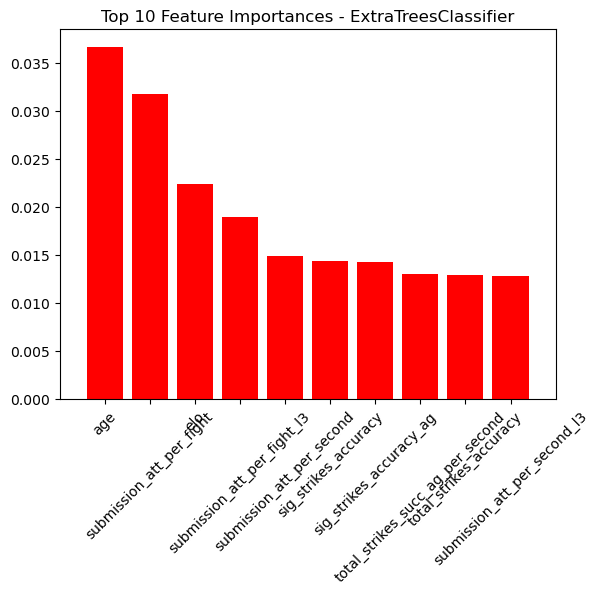

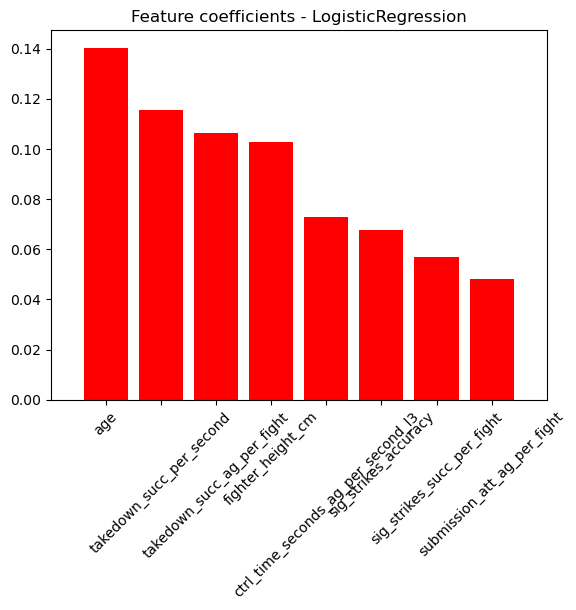

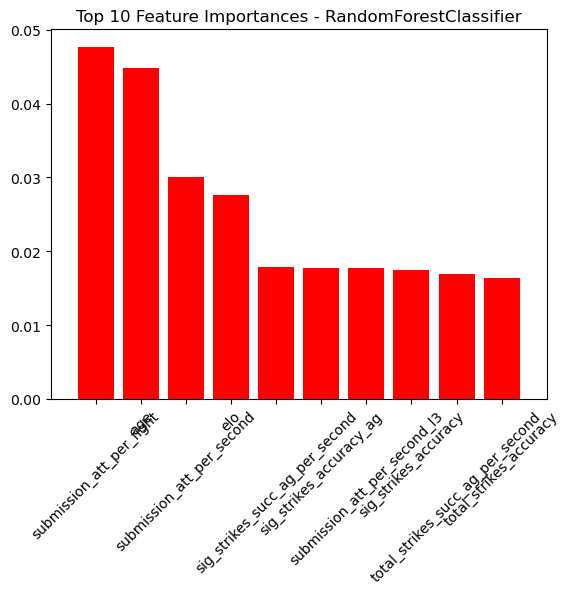

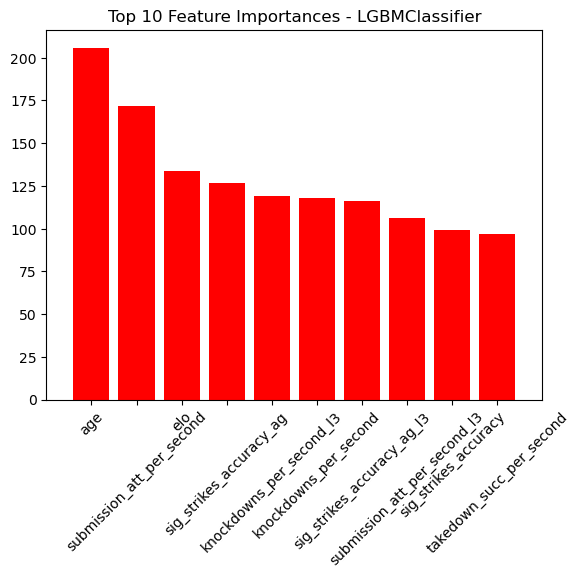

In [39]:
import matplotlib.pyplot as plt
model_feature_pairs = [(best_et_model, best_et_features), (best_lda_model, best_lda_features), (best_hgb_model, best_hgb_features), (best_log_model, best_log_features), (best_rf_model, best_rf_features), (best_xgb_model, best_xgb_features), (best_lgbm_model, best_lgbm_features)]

for model, feature in model_feature_pairs:
    X = features_prepped[list(feature)]  
    feature_names = X.columns
    model.fit(X, target)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        filtered_indices = [i for i in indices if 'win' not in feature_names[i].lower() and 'loss' not in feature_names[i].lower()]
        top_indices = filtered_indices[:10]
        plt.figure()
        plt.title(f"Top 10 Feature Importances - {model.__class__.__name__}")
        plt.bar(range(len(top_indices)), importances[top_indices], color="r", align="center")
        plt.xticks(range(len(top_indices)), [feature_names[i] for i in top_indices], rotation=45)
        plt.xlim([-1, len(top_indices)])
        plt.show()
    elif hasattr(model, "coef_"):
        coefficients = model.coef_[0]
        indices = np.argsort(np.abs(coefficients))[::-1]
        filtered_indices = [i for i in indices if 'win' not in feature_names[i].lower() and 'loss' not in feature_names[i].lower()]
        top_indices = filtered_indices[:8]
        plt.figure()
        plt.title(f"Feature coefficients - {model.__class__.__name__}")
        plt.bar(range(8), np.abs(coefficients)[top_indices], color="r", align="center")
        plt.xticks(range(8), [feature_names[i] for i in top_indices], rotation=45)
        plt.xlim([-1, 8])
        plt.show()
    


## Ensemble Fitting

In [40]:
from sklearn.metrics import log_loss, accuracy_score




folds = []
vals = []
for train_index, val_index in kfold.split(features_prepped):
    X_train = features_prepped.iloc[train_index] 
    X_val = features_prepped.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]
    predictions = []
    
    for i, (model, feature) in enumerate(model_feature_pairs):
        model.fit(X_train[list(feature)], y_train)
        predictions.append(model.predict_proba(X_val[list(feature)]))
    folds.append(predictions) 
    vals.append(y_val)
   


In [41]:
from scipy.optimize import minimize

def ensemble_log_loss(weights, folds, vals):
    exp_sum = np.sum([np.exp(w) for w in weights])
    scores = []
    for j, fold in enumerate(folds):
        prediction = np.zeros((len(vals[j]), 6))
        for i, pred in enumerate(fold):
            prediction += pred * np.exp(weights[i]) / exp_sum 
        score = log_loss(vals[j], prediction)
        scores.append(score)
 
    return np.mean(scores)

# Initial weights
initial_weights = [0.0] * 7

# Call minimize
result = minimize(ensemble_log_loss, initial_weights, args=(folds, vals), method='cobyla')

# Optimal weights
optimal_weights = result.x

print("Optimal weights:", optimal_weights)
print("Minimum log loss:", result.fun)


Optimal weights: [ 0.5856158   2.47935291 -3.19265577 -0.80012097 -3.16648658  2.5179392
  1.08753793]
Minimum log loss: 1.5930958584939865


In [42]:
for (model, feature), weight in zip(model_feature_pairs, optimal_weights):
    print(model.__class__.__name__, np.exp(weight)/np.sum([np.exp(w) for w in optimal_weights]))

ExtraTreesClassifier 0.060613218233863314
LinearDiscriminantAnalysis 0.4027234507529211
HistGradientBoostingClassifier 0.00138574988761791
LogisticRegression 0.01516175630302004
RandomForestClassifier 0.0014224925007321884
XGBClassifier 0.41856675848850994
LGBMClassifier 0.10012657383333554


In [67]:
# Make predictions on the test set
target_test = df_test['result_code']
features_test = df_test[df_test.columns[:-1]]

# Transform the test data
features_prepped_test = pd.DataFrame(scaler.transform(features_test), columns=input.columns)

et_pred = best_et_model.predict_proba(features_prepped_test[list(best_et_features)]) * (np.exp(optimal_weights[0])/np.sum([np.exp(w) for w in optimal_weights]))
lda_pred = best_lda_model.predict_proba(features_prepped_test[list(best_lda_features)]) * (np.exp(optimal_weights[1])/np.sum([np.exp(w) for w in optimal_weights]))
hgb_pred = best_hgb_model.predict_proba(features_prepped_test[list(best_hgb_features)]) * (np.exp(optimal_weights[2])/np.sum([np.exp(w) for w in optimal_weights]))
log_pred = best_log_model.predict_proba(features_prepped_test[list(best_log_features)]) * (np.exp(optimal_weights[3])/np.sum([np.exp(w) for w in optimal_weights]))
rf_pred = best_rf_model.predict_proba(features_prepped_test[list(best_rf_features)]) * (np.exp(optimal_weights[4])/np.sum([np.exp(w) for w in optimal_weights]))
xgb_pred = best_xgb_model.predict_proba(features_prepped_test[list(best_xgb_features)]) * (np.exp(optimal_weights[5])/np.sum([np.exp(w) for w in optimal_weights]))
lgbm_pred = best_lgbm_model.predict_proba(features_prepped_test[list(best_lgbm_features)]) * (np.exp(optimal_weights[6])/np.sum([np.exp(w) for w in optimal_weights]))

# Sum up the weighted predictions
ensemble_pred = et_pred + lda_pred + hgb_pred + log_pred + rf_pred + xgb_pred + lgbm_pred
ensemble_pred_labels = np.argmax(ensemble_pred, axis=1)
print('Ensemble Test Log Loss', log_loss(target_test, ensemble_pred))
print('Ensemble Test Accuracy', accuracy_score(target_test, ensemble_pred_labels))

Ensemble Test Log Loss 1.6758224257440333
Ensemble Test Accuracy 0.2914438502673797


In [66]:
features_prepped_test

elo       age  days_since_last_fight  count_RunningTotal  \
0   -0.170224 -0.548663              -3.145616           -1.820705   
1    2.357823  0.830080               0.252982            1.559786   
2    0.242157  0.703043               1.290449           -0.243142   
3    0.636247 -0.091329              -1.678853           -0.243142   
4   -0.858197  0.845117               1.683971           -0.017776   
..        ...       ...                    ...                 ...   
369  0.565731 -0.111032               1.612421           -0.243142   
370  1.295032  0.284598              -0.462513            0.207590   
371  1.348595 -0.420070              -0.176315           -1.144607   
372 -0.521855 -0.771107               0.896927           -1.820705   
373 -0.201306 -0.594811              -0.104765           -0.017776   

     fighter_height_cm  fighter_reach_cm  knockdowns_per_second  \
0            -0.790274         -0.635708               0.212481   
1            -0.378914         -0.635708              -0.554646   
2            -0.378914         -0.010449               0.402624   
3             2.500610          2.177959               0.533446   
4             0.443807          1.552700               1.115458   
..                 ...               ...                    ...   
369           0.032447          0.927440              -0.157757   
370           1.266529          3.115848               0.897177   
371           1.266529          0.927440               0.306887   
372           1.266529         -0.323079              -0.159332   
373          -0.790274          0.302181               0.223952   

     knockdowns_per_fight  knockdowns_ag_per_second  knockdowns_ag_per_fight  \
0                0.250266                  0.114715                -0.043241   
1               -1.451493                 -0.008543                -0.043241   
2                0.761423                 -0.580722                -1.015632   
3                0.761423                  0.314618                -0.043241   
4                1.763290                  0.941954                 1.123629   
..                    ...                       ...                      ...   
369             -0.812940                  0.059864                -0.043241   
370              1.190794                  0.739806                 0.734672   
371              0.681909                 -0.154782                -0.342438   
372             -0.567585                  0.003509                -0.043241   
373              0.352497                 -1.049170                -1.779654   

     ...  ko_loss_percentage  ko_loss_percentage_l3  sub_win_percentage  \
0    ...            0.369520               1.230769            0.633376   
1    ...           -0.018406              -0.053213           -0.193701   
2    ...           -0.018406              -0.053213           -1.085693   
3    ...            1.339336               1.230769            0.008260   
4    ...            1.610884               2.514752            0.008260   
..   ...                 ...                    ...                 ...   
369  ...            1.067787              -0.053213            0.008260   
370  ...           -0.018406              -0.053213           -0.575182   
371  ...            0.585035               1.230769           -0.664942   
372  ...           -0.018406              -0.053213            0.320818   
373  ...            0.660465              -0.053213           -0.616856   

     sub_win_percentage_l3  sub_loss_percentage  sub_loss_percentage_l3  \
0                 0.015670            -0.006825               -0.051146   
1                -1.218123            -0.006825               -0.051146   
2                -1.218123            -0.006825               -0.051146   
3                 0.015670            -1.710981               -1.790117   
4                 0.015670            -1.521630               -1.790117   
..                     ...                  ...     

In [63]:
target_test

1502    1
1503    0
1504    1
1505    1
1506    4
       ..
1876    5
1877    2
1878    1
1879    0
1880    4
Name: result_code, Length: 374, dtype: int64

In [44]:

numerical_columns = ['knockdowns', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att',
       'sig_strikes_succ', 'takedown_att', 'takedown_succ', 'submission_att',
       'reversals', 'ctrl_time_seconds', 'finish_time_seconds', 'count']
result_columns = ['win', 'ko_win', 'ko_loss', 'sub_win', 'sub_loss', 'dec_win', 'dec_loss']
accuracy_columns = ['total_strikes', 'sig_strikes']
for column in numerical_columns[:-2]:
    data = []
    name = column+'_ag'
    stats = list(df[column])
    for i, stat in enumerate(stats):
        if i % 2 == 0:
            data.append(stats[i+1])
            data.append(stat)
    df[name] = data
    

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() 
    if column != 'finish_time_seconds' and column != 'count' and 'win' not in column and 'loss' not in column:
        df[f'{column}_ag_RunningTotal'] = df.groupby('name')[column+'_ag'].cumsum() 
for column in result_columns:
    df[f'{column}_RunningTotal'] = df.groupby('name')[column].cumsum() 
mask = [True]*len(df)
for i, count in enumerate(list(df.count_RunningTotal)):
    if i % 2 == 0:
        if count < 3 or list(df.count_RunningTotal)[i+1] < 3:
            mask[i] = False
            mask[i+1] = False
for column in numerical_columns[:-2]:
    df[column+'_per_second'] = df[column+'_RunningTotal'] / df['finish_time_seconds_RunningTotal'] 
    df[column+'_per_fight'] = df[column+'_RunningTotal'] / df['count_RunningTotal'] 
    df[column+'_ag'+'_per_second'] = df[column+'_ag'+'_RunningTotal'] / df['finish_time_seconds_RunningTotal']
    df[column+'_ag'+'_per_fight'] = df[column+'_ag'+'_RunningTotal'] / df['count_RunningTotal']

df['time_per_fight'] = df['finish_time_seconds_RunningTotal'] / df['count_RunningTotal']
for column in accuracy_columns:
    df[column+'_accuracy'] = df[column+'_succ_RunningTotal'] / df[column+'_att_RunningTotal'] 
    df[column+'_accuracy_ag'] = df[column+'_succ_ag_RunningTotal'] / df[column+'_att_ag_RunningTotal'] 

# Compute running total for each numerical column per fighter
for column in numerical_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.rolling(window=3, min_periods=1).sum())
    if column != 'finish_time_seconds' and column != 'count':
        df[f'{column}_ag_RunningTotal_l3'] = df.groupby('name')[column+'_ag'].transform(lambda x: x.rolling(window=3, min_periods=1).sum())

for column in result_columns:
    df[f'{column}_RunningTotal_l3'] = df.groupby('name')[column].transform(lambda x: x.rolling(window=3, min_periods=1).sum()) 

for column in numerical_columns[:-2]:
    df[column+'_per_second_l3'] = df[column+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3'] 
    df[column+'_per_fight_l3'] = df[column+'_RunningTotal_l3'] / df['count_RunningTotal_l3']    
    df[column+'_ag'+'_per_second_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['finish_time_seconds_RunningTotal_l3']
    df[column+'_ag'+'_per_fight_l3'] = df[column+'_ag'+'_RunningTotal_l3'] / df['count_RunningTotal_l3']

df['time_per_fight_l3'] = df['finish_time_seconds_RunningTotal_l3'] / df['count_RunningTotal_l3']
for column in accuracy_columns:
    df[column+'_accuracy_l3'] = df[column+'_succ_RunningTotal_l3'] / df[column+'_att_RunningTotal_l3'] 
    df[column+'_accuracy_ag_l3'] = df[column+'_succ_ag_RunningTotal_l3'] / df[column+'_att_ag_RunningTotal_l3'] 

for column in result_columns:
    df[column+'_percentage'] = df[f'{column}_RunningTotal'] / df['count_RunningTotal']
    df[column+'_percentage_l3'] = df[f'{column}_RunningTotal_l3'] / df['count_RunningTotal_l3']

df_filtered = df[mask]
df_filtered

fight_stat_id  fight_id  fighter_id  knockdowns  total_strikes_att  \
8787           5649      2825      3185.0         1.0               30.0   
8786           5650      2825      2594.0         0.0               27.0   
8763           5673      2837      3308.0         0.0              177.0   
8762           5674      2837      2467.0         1.0              221.0   
8761           5675      2838       773.0         0.0               41.0   
...             ...       ...         ...         ...                ...   
4             14432      7216       981.0         0.0              130.0   
3             14433      7217      2464.0         0.0               72.0   
2             14434      7217      1662.0         0.0               59.0   
1             14435      7218      2884.0         0.0               42.0   
0             14436      7218      2976.0         0.0               34.0   

      total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
8787                18.0             30.0              18.0           0.0   
8786                10.0             27.0              10.0           1.0   
8763                57.0            177.0              57.0           5.0   
8762                93.0            221.0              93.0           0.0   
8761                34.0             18.0              13.0           3.0   
...                  ...              ...               ...           ...   
4                   90.0            102.0              70.0           1.0   
3                   32.0             55.0              18.0           0.0   
2                   37.0             40.0              23.0          15.0   
1                   17.0             40.0              16.0           6.0   
0                   19.0             32.0              18.0           0.0   

      takedown_succ  ...  ko_loss_percentage  ko_loss_percentage_l3  \
8787            0.0  ...            0.000000               0.000000   
8786            0.0  ...            0.333333               0.333333   
8763            0.0  ...            0.333333               0.333333   
8762            0.0  ...            0.000000               0.000000   
8761            3.0  ...            0.000000               0.000000   
...             ...  ...                 ...                    ...   
4               1.0  ...            0.100000               0.333333   
3               0.0  ...            0.000000               0.000000   
2               5.0  ...            0.000000               0.000000   
1               1.0  ...            0.000000               0.000000   
0               0.0  ...            0.222222               0.333333   

     sub_win_percentage sub_win_percentage_l3  sub_loss_percentage  \
8787           0.000000              0.000000             0.000000   
8786           0.333333              0.333333             0.000000   
8763           0.000000              0.000000             0.000000   
8762           0.000000              0.000000             0.333333   
8761           0.000000              0.000000             0.333333   
...                 ...                   ...                  ...   
4              0.000000              0.000000             0.000000   
3              0.066667              0.000000             0.000000   
2              0.125000              0.000000             0.125000   
1              0.125000              0.000000             0.000000   
0              0.000000              0.000000             0.000000   

     sub_loss_percentage_l3  dec_win_percentage  dec_win_percentage_l3  \
8787               0.000000            0.000000               0.000000   
8786               0.000000            0.333333               0.333333   
8763               0.000000            0.333333               0.333333   
8762               0.333333            0.333333               0.333333   
8761               0.333333            0.333333               0.333333   
...                     ...   

In [45]:
from collections import defaultdict

def dd():
    return {}

rating = defaultdict(dd)
for i, row in df_filtered.iterrows():
    for column in features_prepped.columns:
        try:
            if column == 'elo':
                rating[column][row['name']] = elo[row['fighter_id']]
            else:
                rating[column][row['name']] = row[column]
        except:
            pass
rating   

defaultdict(<function __main__.dd()>,
            {'elo': {'Rafael Dos Anjos': 1653.4677199526275,
              'Benson Henderson': 1579.1432269949635,
              'Rodrigo Damm': 1412.9351181642876,
              'Al Iaquinta': 1553.8807933469345,
              'Justin Scoggins': 1400.7474444932895,
              'John Moraga': 1545.0957687405605,
              'Russell Doane': 1443.7607921580288,
              'Iuri Alcantara': 1529.033317384011,
              'Sam Sicilia': 1405.1056255040505,
              'Katsunori Kikuno': 1436.8576351309882,
              'Rick Story': 1552.716315553132,
              'Gunnar Nelson': 1670.720212662771,
              'Wilson Reis': 1500.1326021197278,
              'Scott Jorgensen': 1374.951175248383,
              'Beneil Dariush': 1779.535815334268,
              'Diego Ferreira': 1616.6092959524462,
              'Clint Hester': 1421.2210513224838,
              'Robert Whittaker': 1733.996321655185,
              'Ross Pearson': 1378.94

In [46]:
per_sec_mask = []
for i, column in enumerate(features_prepped.columns):
    if 'second' in column and 'l3' not in column:
        per_sec_mask.append(True)
    else:
        per_sec_mask.append(False)
per_sec_mask = np.array(per_sec_mask).reshape(-1,1).T
per_sec_mask

array([[False, False, False, False, False, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False,  True, False,  True, False,  True, False,
         True, False,  True, False,  True, False,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]])

In [74]:

def preview(f1, f2):
    metrics = np.array([rating[col][f2] - rating[col][f1] for col in rating]).reshape(-1, 1).T
    metrics_scaled = scaler.transform(metrics)
    metrics_scaled_df = pd.DataFrame(metrics_scaled, columns=features_prepped.columns)
    comps = []
    for i, row in prev_fights.iterrows():
        row_arr = np.array(row).reshape(-1,1).T
        score1 = np.abs(metrics_scaled-row_arr)[per_sec_mask].sum()
        score2 = np.abs(metrics_scaled+row_arr)[per_sec_mask].sum()
        comps.append(min(score1, score2))
    comp_table = pd.DataFrame(index=names.index)
    comp_table['comps'] = comps
    similar_fights = names.loc[comp_table.sort_values('comps').index[:10]]
    # Make prediction
    et_pred = best_et_model.predict_proba(metrics_scaled_df[list(best_et_features)]) * (np.exp(optimal_weights[0])/np.sum([np.exp(w) for w in optimal_weights]))
    lda_pred = best_lda_model.predict_proba(metrics_scaled_df[list(best_lda_features)]) * (np.exp(optimal_weights[1])/np.sum([np.exp(w) for w in optimal_weights]))
    hgb_pred = best_hgb_model.predict_proba(metrics_scaled_df[list(best_hgb_features)]) * (np.exp(optimal_weights[2])/np.sum([np.exp(w) for w in optimal_weights]))
    log_pred = best_log_model.predict_proba(metrics_scaled_df[list(best_log_features)]) * (np.exp(optimal_weights[3])/np.sum([np.exp(w) for w in optimal_weights]))
    rf_pred = best_rf_model.predict_proba(metrics_scaled_df[list(best_rf_features)]) * (np.exp(optimal_weights[4])/np.sum([np.exp(w) for w in optimal_weights]))
    xgb_pred = best_xgb_model.predict_proba(metrics_scaled_df[list(best_xgb_features)]) * (np.exp(optimal_weights[5])/np.sum([np.exp(w) for w in optimal_weights]))
    lgbm_pred = best_lgbm_model.predict_proba(metrics_scaled_df[list(best_lgbm_features)]) * (np.exp(optimal_weights[6])/np.sum([np.exp(w) for w in optimal_weights]))
    
    # Sum up the weighted predictions
    ensemble_pred = et_pred + lda_pred + hgb_pred + log_pred + rf_pred + xgb_pred + lgbm_pred
    prediction = pd.DataFrame(ensemble_pred, columns=[f1+'_decision', f1+'_ko', f1+'_sub', f2+'_decision', f2+'_ko', f2+'_sub'])
    return prediction

metrics_scaled = preview('Sean Strickland', 'Israel Adesanya')
metrics_scaled

Sean Strickland_decision  Sean Strickland_ko  Sean Strickland_sub  \
0                  0.464771            0.160141             0.065715   

   Israel Adesanya_decision  Israel Adesanya_ko  Israel Adesanya_sub  
0                  0.167544            0.108941             0.032889

In [ ]:
similar_fights

In [ ]:
for 
elo[679]

In [73]:
target.mean()

1.9512032085561497

In [72]:
for model, feature in model_feature_pairs:
    print(model)

ExtraTreesClassifier(criterion='entropy', max_features=0.9500000000000001,
                     min_samples_leaf=7, min_samples_split=20, n_jobs=-1,
                     random_state=42)
LinearDiscriminantAnalysis(shrinkage=0.1, solver='eigen', tol=1e-05)
HistGradientBoostingClassifier(l2_regularization=0.05, learning_rate=0.01,
                               max_bins=238, max_depth=4, max_features=0.25,
                               min_samples_leaf=9, random_state=42)
LogisticRegression(C=0.01, n_jobs=-1, random_state=42, tol=0.001)
RandomForestClassifier(criterion='entropy', max_features=0.45,
                       min_samples_leaf=16, min_samples_split=13, n_jobs=-1,
                       random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
